In [1]:
# Importe
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from utils import load_all_batches
import matplotlib.pyplot as plt


# Die Klasse macht aus Numpy-Daten (X_train_seq, y_train) ein PyTorch kompatibles Dataset
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
            return len(self.X)

    def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

In [2]:
# LSTM-Modell Klasse
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lr=0.001):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        # Erwartet: (Batch, SeqLen, Features)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # letzter Zeitschritt
        out = self.fc(out)
        return out

    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch

        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train_model(self, train_loader, epochs):
        all_losses = []
        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_loss = total_loss / len(train_loader)
            all_losses.append(avg_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        # Neu: Plotte die Losse danach
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), all_losses, marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Average Training Loss")
        plt.title("LSTM Training Loss")
        plt.grid(True)
        plt.show()
        return all_losses
        

    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = self(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy

    def save_model(self,path):
        torch.save(self.state_dict(), path)

    def load_model(self, path, map_location=None):
        self.load_state_dict(torch.load(path, map_location=map_location))
        

In [3]:
# Datenvorbereitung

folderpath = r"gas+sensor+array+drift+dataset/Dataset"
df = load_all_batches(folderpath)

# Features & Labels
X = df.iloc[:, 0:128].values
y = df.iloc[:, 128].values

# Normalisieren
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sequenzlänge 
SEQ_LEN = 50

# Funktion zum Erstellen von Sequenzen aus den Daten
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1]) # Gaslabel
    return np.array(xs), np.array(ys)

# Sequenzen erstellen
X_train_seq, y_train_seq = create_sequences(X_train, y_train - 1, SEQ_LEN) # Labels 0-basiert
X_test_seq, y_test_seq = create_sequences(X_test, y_test - 1, SEQ_LEN)

# PyTorch Dataset + Loader
train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Using device: cpu
Epoch [1/30], Loss: 1.5899
Epoch [2/30], Loss: 1.1769
Epoch [3/30], Loss: 0.9364
Epoch [4/30], Loss: 0.7892
Epoch [5/30], Loss: 0.6890
Epoch [6/30], Loss: 0.6194
Epoch [7/30], Loss: 0.5670
Epoch [8/30], Loss: 0.5182
Epoch [9/30], Loss: 0.4771
Epoch [10/30], Loss: 0.4466
Epoch [11/30], Loss: 0.4193
Epoch [12/30], Loss: 0.3969
Epoch [13/30], Loss: 0.3813
Epoch [14/30], Loss: 0.3578
Epoch [15/30], Loss: 0.3406
Epoch [16/30], Loss: 0.3271
Epoch [17/30], Loss: 0.3141
Epoch [18/30], Loss: 0.3010
Epoch [19/30], Loss: 0.2884
Epoch [20/30], Loss: 0.2809
Epoch [21/30], Loss: 0.2755
Epoch [22/30], Loss: 0.2620
Epoch [23/30], Loss: 0.2517
Epoch [24/30], Loss: 0.2452
Epoch [25/30], Loss: 0.2399
Epoch [26/30], Loss: 0.2320
Epoch [27/30], Loss: 0.2256
Epoch [28/30], Loss: 0.2231
Epoch [29/30], Loss: 0.2157
Epoch [30/30], Loss: 0.2061


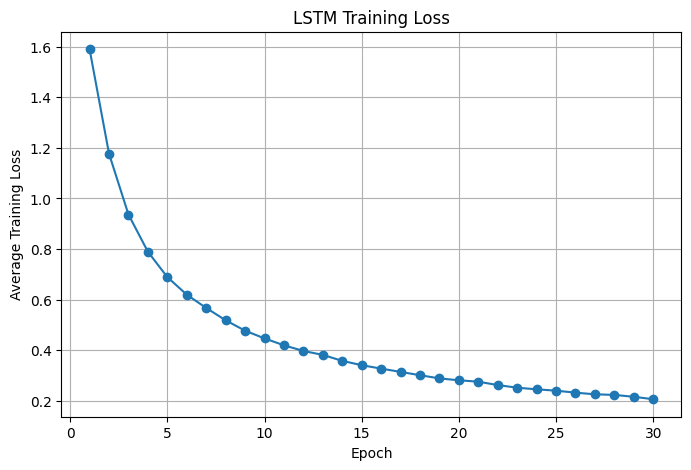

Test Accuracy: 0.9513


In [4]:
# Training starten

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(input_size=128, hidden_size=64, num_layers=1, num_classes=6, lr=0.0005)
model.to(device)

# Trainieren
model.train_model(train_loader, epochs=30)

# Evaluieren
model.evaluate(test_loader)

# speichern
model.save_model("lstm_batch1.pth")


--- Fold 1/5 ---
Epoch [1/30], Loss: 1.4094
Epoch [2/30], Loss: 1.0618
Epoch [3/30], Loss: 0.8996
Epoch [4/30], Loss: 0.7934
Epoch [5/30], Loss: 0.6936
Epoch [6/30], Loss: 0.6283
Epoch [7/30], Loss: 0.5792
Epoch [8/30], Loss: 0.5220
Epoch [9/30], Loss: 0.4634
Epoch [10/30], Loss: 0.4103
Epoch [11/30], Loss: 0.3754
Epoch [12/30], Loss: 0.3291
Epoch [13/30], Loss: 0.3199
Epoch [14/30], Loss: 0.4414
Epoch [15/30], Loss: 0.3461
Epoch [16/30], Loss: 0.2618
Epoch [17/30], Loss: 0.2513
Epoch [18/30], Loss: 0.2406
Epoch [19/30], Loss: 0.2351
Epoch [20/30], Loss: 0.2793
Epoch [21/30], Loss: 0.2687
Epoch [22/30], Loss: 0.1903
Epoch [23/30], Loss: 0.2031
Epoch [24/30], Loss: 0.1849
Epoch [25/30], Loss: 0.1581
Epoch [26/30], Loss: 0.1966
Epoch [27/30], Loss: 0.1708
Epoch [28/30], Loss: 0.1402
Epoch [29/30], Loss: 0.1531
Epoch [30/30], Loss: 0.1277


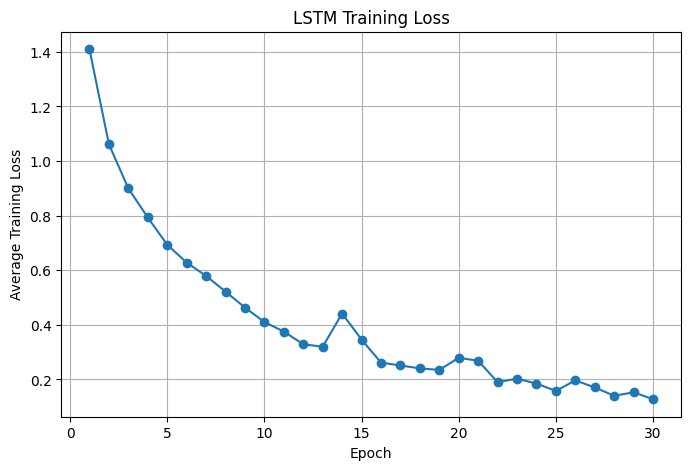

Test Accuracy: 0.9668

--- Fold 2/5 ---
Epoch [1/30], Loss: 1.3707
Epoch [2/30], Loss: 0.9851
Epoch [3/30], Loss: 0.8684
Epoch [4/30], Loss: 0.7788
Epoch [5/30], Loss: 0.7241
Epoch [6/30], Loss: 0.6639
Epoch [7/30], Loss: 0.5995
Epoch [8/30], Loss: 0.5548
Epoch [9/30], Loss: 0.4912
Epoch [10/30], Loss: 0.4641
Epoch [11/30], Loss: 0.4430
Epoch [12/30], Loss: 0.4110
Epoch [13/30], Loss: 0.3687
Epoch [14/30], Loss: 0.3395
Epoch [15/30], Loss: 0.3299
Epoch [16/30], Loss: 0.2883
Epoch [17/30], Loss: 0.2942
Epoch [18/30], Loss: 0.2703
Epoch [19/30], Loss: 0.2642
Epoch [20/30], Loss: 0.2689
Epoch [21/30], Loss: 0.2270
Epoch [22/30], Loss: 0.2194
Epoch [23/30], Loss: 0.2003
Epoch [24/30], Loss: 0.1903
Epoch [25/30], Loss: 0.2042
Epoch [26/30], Loss: 0.1768
Epoch [27/30], Loss: 0.1665
Epoch [28/30], Loss: 0.1692
Epoch [29/30], Loss: 0.1634
Epoch [30/30], Loss: 0.2180


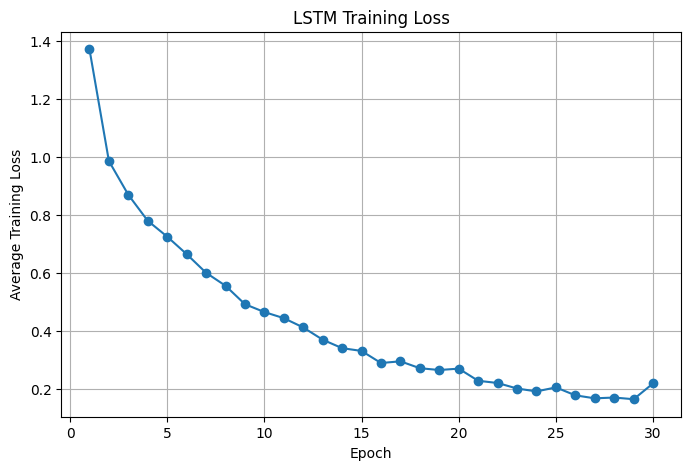

Test Accuracy: 0.9394

--- Fold 3/5 ---
Epoch [1/30], Loss: 1.3710
Epoch [2/30], Loss: 0.9650
Epoch [3/30], Loss: 0.7932
Epoch [4/30], Loss: 0.7524
Epoch [5/30], Loss: 0.6660
Epoch [6/30], Loss: 0.5968
Epoch [7/30], Loss: 0.5787
Epoch [8/30], Loss: 0.5172
Epoch [9/30], Loss: 0.4582
Epoch [10/30], Loss: 0.4104
Epoch [11/30], Loss: 0.3994
Epoch [12/30], Loss: 0.3627
Epoch [13/30], Loss: 0.3195
Epoch [14/30], Loss: 0.3090
Epoch [15/30], Loss: 0.2864
Epoch [16/30], Loss: 0.3144
Epoch [17/30], Loss: 0.2576
Epoch [18/30], Loss: 0.2773
Epoch [19/30], Loss: 0.2357
Epoch [20/30], Loss: 0.2392
Epoch [21/30], Loss: 0.3751
Epoch [22/30], Loss: 0.2589
Epoch [23/30], Loss: 0.2353
Epoch [24/30], Loss: 0.1902
Epoch [25/30], Loss: 0.2347
Epoch [26/30], Loss: 0.1772
Epoch [27/30], Loss: 0.1821
Epoch [28/30], Loss: 0.1607
Epoch [29/30], Loss: 0.1443
Epoch [30/30], Loss: 0.1451


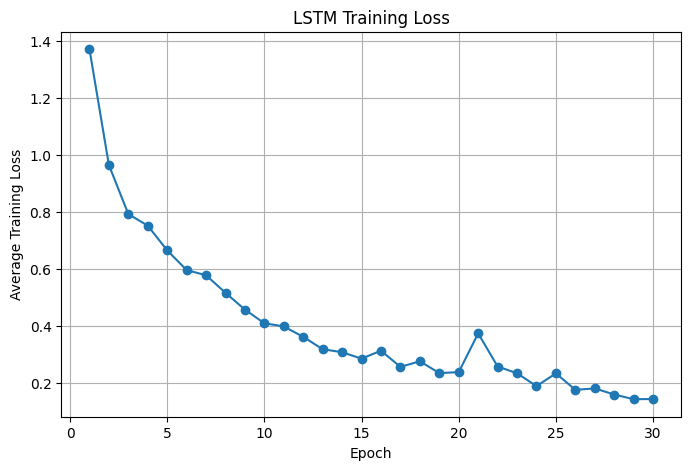

Test Accuracy: 0.9423

--- Fold 4/5 ---
Epoch [1/30], Loss: 1.4025


KeyboardInterrupt: 

In [5]:
# NEU: 5-Fold Cross Validation

# Sequenzen erstellen
X_seq, y_seq = create_sequences(X, y - 1, SEQ_LEN)  # Labels 0-basiert

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n--- Fold {fold+1}/{5} ---")

    X_train_fold, y_train_fold = X_seq[train_idx], y_seq[train_idx]
    X_val_fold, y_val_fold = X_seq[val_idx], y_seq[val_idx]

    train_dataset = GasSensorDataset(X_train_fold, y_train_fold)
    val_dataset = GasSensorDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Neues Modell für jeden Fold
    model = LSTM(input_size=128, hidden_size=64, num_layers=1, num_classes=6, lr=0.0005)
    model.to(device)

    model.train_model(train_loader, epochs=30)

    acc = model.evaluate(val_loader)
    fold_accuracies.append(acc)

# Durchschnittliche Accuracy
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across 5 folds: {avg_acc:.4f}")